### Escreva aqui seu nome: Mateus Oliveira

1.   Item da lista
2.   Item da lista



# PyTorch: Gradientes e Grafo Computacional

## Objetivos

Este notebook introduz 
- o conceito de autograd do PyTorch,
- uma interpretação numérica intuitiva do gradiente, e o
- grafo computacional, utilizado para o cálculo automático do gradiente de uma função.

Um dos principais fundamentos para que o PyTorch seja adequado para deep learning é a sua habilidade de
calcular o gradiente automaticamente a partir da expressões definidas. Essa facilidade é implementada
pelo tensor através do cálculo automático do gradiente pela construção dinâmica do grafo computacional.

## Grafo computacional

```
    y_pred = x * w
    e = y_pred - y
    e2 = e**2
    J = e2.sum()
```

<img src="https://raw.githubusercontent.com/robertoalotufo/files/master/figures/GrafoComputacional.png" width="600pt"/>

Para conhecer com maior profundidade a diferenciação automática usando grafo computacional, veja esta nota de aula:
https://cs231n.github.io/optimization-2/

In [1]:
import torch

In [2]:
torch.__version__

'1.10.0+cu111'

## Se um tensor possui .requires_grad=True

In [3]:
y = 2 * torch.arange(0,4).float()
y

tensor([0., 2., 4., 6.])

In [4]:
x = torch.arange(0,4).float(); x

tensor([0., 1., 2., 3.])

In [5]:
w = torch.ones(1,requires_grad=True); w

tensor([1.], requires_grad=True)

## Cálculo automático do gradiente da função perda J

Seja a expressão: $$ J = \sum ((x  w) - y)^2 $$

Queremos calcular a derivada de $J$ em relação a $w$.

### Montagem do grafo computacional

In [6]:
# predict (forward)
y_pred = x * w

# cálculo da perda J: loss
e = y_pred - y
e2 = e.pow(2)
J = e2.sum()
J

tensor(14., grad_fn=<SumBackward0>)

## Auto grad - processa o grafo computacional backwards

O `backward()` varre o grafo computacional a partir da variável a ele associada e calcula o gradiente para todos os tensores que possuem o atributo `requires_grad` como verdadeiro.
O `backward()` destroi o grafo após sua execução. Isso é intrínsico ao PyTorch pelo fato dele ser uma rede dinâmica.

In [7]:
J.backward()
print(w.grad)

tensor([-28.])


In [8]:
w.grad.data.zero_();

## Interpretação do Gradiente

O gradiente de uma variável final (J) com respeito à outra variável de entrada (w) pode ser interpretado como o quanto a variável final J vai aumentar se houver um pequeno aumento na variável de entrada (w).
Por exemplo suponha que o gradiente seja 28. Isto significa se aumentarmos a variável w de 0.001, então J vai aumentar de 0.028.

In [9]:
eps = 0.001
y_pred = x * (w + eps)
J_new = (y_pred - y).pow(2).sum()
J_new

tensor(13.9720, grad_fn=<SumBackward0>)

In [10]:
print(J_new - J)

tensor(-0.0280, grad_fn=<SubBackward0>)


## Backpropagation

Uma forma equivalente explícita de calcular o gradiente é fazendo o processamento do backpropagation no grafo computacional, de forma explícita.
Apenas como ilustração.

In [11]:
import numpy as np

dJ = 1.
de2 = dJ * np.ones((4,))
de = de2 * 2 * e.data.numpy()
dy_pred = de
dw = (dy_pred * x.data.numpy()).sum()
print(dJ)
print(de2)
print(de)
print(dw)

1.0
[1. 1. 1. 1.]
[ 0. -2. -4. -6.]
-28.0


## Visualizando o grafo computacional

In [12]:
!pip install torchviz

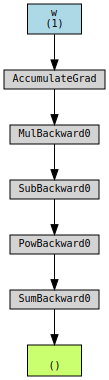

In [13]:
import torchviz
J = ((w * x) - y).pow(2).sum()
p = {'w':w} # dicionário de parâmetros
out = torchviz.make_dot(J,params=p)
out

Iremos agora visualizar a Resnet, que é uma rede neural bastante popular em visão computacional.

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


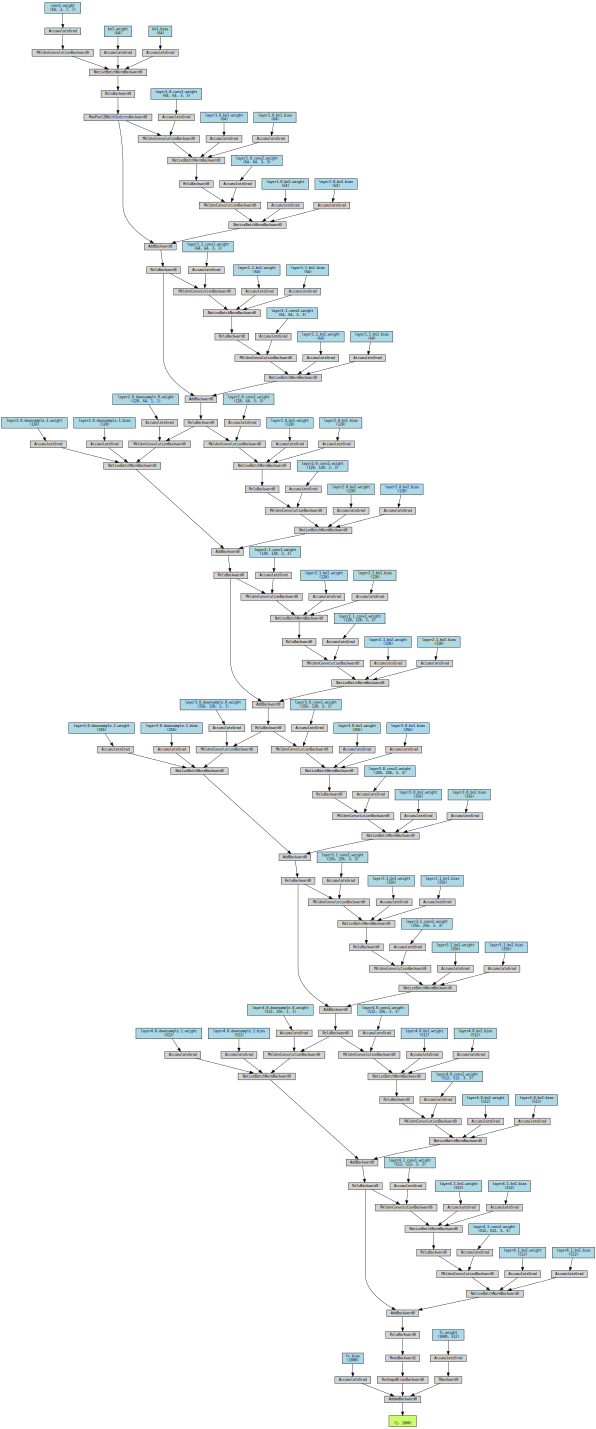

In [14]:
import torch
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
x_temp = torch.randn(1,3,224,224)  # First, create a random image.
y_temp = model(x_temp)  # We need one forward pass so the graph can be build.
out = torchviz.make_dot(y_temp, params=dict(model.named_parameters()))  # Create a figure from the computaional graph..
torchviz.dot.resize_graph(out, size_per_element=0.05)  # Resize to fit on the screen.
out

# Exercício 1

O que acontece com o grafo computacional após execução do `backward()`?

Resposta: O grafo computacional é destruido. e os valores dos pesos são atualizados.

# Exercício 2

Execute um passo de atualização do valor de w, pelo 
gradiente descendente. Utilize um fator de aprendizado (*learning rate*) de 0.01 
para atualizar o `w`. Após, recalcule a função de perda:

    - w = w - lr * w.grad.data
    - Verifique o quanto que a perda J diminuiu

In [15]:
#raise Exception("Escreva seu código aqui")
lr = 0.01
w = w - lr * w.grad.data

In [16]:
J = ((w * x) - y).pow(2).sum()
w,J

(tensor([1.], grad_fn=<SubBackward0>), tensor(14., grad_fn=<SumBackward0>))

In [17]:
eps = 0.001
y_pred = x * (w + eps)
J_new = (y_pred - y).pow(2).sum()
J_new

tensor(13.9720, grad_fn=<SumBackward0>)

In [18]:
print(J_new - J)

tensor(-0.0280, grad_fn=<SubBackward0>)


## Treinando uma rede no Pytorch

Para ajudar na entendimento dos exercícios abaixo, apresentamos o código em Pytorch para treinar uma rede de uma camada não-linear, com pesos `w` e `b`:
$y' = \sigma(wx + b)$

<img src="https://github.com/robertoalotufo/files/blob/master/figures/simple_graph.png?raw=true" width="600pt"/>

In [19]:
# É importante fixar as seeds para passar nos asserts abaixo.

import random
import numpy as np
import torch

random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

In [20]:
from typing import List

class NonLinearPytorch(torch.nn.Module):
    def __init__(self):
        super(NonLinearPytorch, self).__init__()

        self.layer1 = torch.nn.Linear(1, 1)
        # Inicializa os pesos w e b em zero.
        self.layer1.load_state_dict(dict(weight=torch.zeros(1,1), bias=torch.zeros(1)))
        
    def forward(self, x):
        y_pred = torch.sigmoid(self.layer1(x))
        return y_pred

learning_rate = 0.1
model = NonLinearPytorch()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
x = torch.tensor([-5], dtype=torch.float)
y_target = torch.tensor([0.76], dtype=torch.float)
num_iterations = 50
for i in range(num_iterations):
    # Zere os gradientes dos passo anterior.
    optimizer.zero_grad()
    # Rode a um passo forward do modelo.
    y_pred = model.forward(x)
    # Calcule a loss
    loss = loss_fn(y_pred, y_target)
    # Calcule os gradientes
    loss.backward()
    # Atualize os pesos
    optimizer.step()

    print(f'iter:{i}: y_prime: {y_pred}')

iter:0: y_prime: tensor([0.5000], grad_fn=<SigmoidBackward0>)
iter:1: y_prime: tensor([0.5837], grad_fn=<SigmoidBackward0>)
iter:2: y_prime: tensor([0.6366], grad_fn=<SigmoidBackward0>)
iter:3: y_prime: tensor([0.6702], grad_fn=<SigmoidBackward0>)
iter:4: y_prime: tensor([0.6926], grad_fn=<SigmoidBackward0>)
iter:5: y_prime: tensor([0.7083], grad_fn=<SigmoidBackward0>)
iter:6: y_prime: tensor([0.7196], grad_fn=<SigmoidBackward0>)
iter:7: y_prime: tensor([0.7281], grad_fn=<SigmoidBackward0>)
iter:8: y_prime: tensor([0.7345], grad_fn=<SigmoidBackward0>)
iter:9: y_prime: tensor([0.7395], grad_fn=<SigmoidBackward0>)
iter:10: y_prime: tensor([0.7435], grad_fn=<SigmoidBackward0>)
iter:11: y_prime: tensor([0.7466], grad_fn=<SigmoidBackward0>)
iter:12: y_prime: tensor([0.7491], grad_fn=<SigmoidBackward0>)
iter:13: y_prime: tensor([0.7511], grad_fn=<SigmoidBackward0>)
iter:14: y_prime: tensor([0.7527], grad_fn=<SigmoidBackward0>)
iter:15: y_prime: tensor([0.7540], grad_fn=<SigmoidBackward0>)
it

# Exercício 3

Vamos agora escrever nosso próprio código para calcular os gradientes da rede apresentada acima.

Para tanto, temos que primeiro implementar a classe Tensor, que é parecida com a classe Tensor do pytorch. Quando instanciada, o objeto resultante armazena o valor do tensor e uma referencia para o nó do grafo computacional que gerou os valores do tensor, quando houver. Com isso podemos construir percorrer o grafo computacional no sentido reverso, realizando o passo `backward` do algoritmo de backpropagation.

Para simplificar a implementação, o gradiente também pode ser armazenado nesta variável. Com isso, podemos tratar os pesos da rede como Tensor's. Isso dispensa a necessidade de criarmos a classe Parameters, como é feito no pytorch.

In [21]:
class Tensor():
  def __init__(self, data: float, previous_node=None):
    self.data = data
    self.previous_node = previous_node
    self.grad = 0.0

  def backward(self, upstream_grad: float = None):
      # Esta vai ser uma chamada recursiva cujo critéria de parada é quando previous_node==None.
      #raise Exception("Escreva seu código aqui")
    
    if upstream_grad is None:
      upstream_grad = 1.0
    if self.previous_node is not None:
      self.previous_node.backward(upstream_grad)

  # Implementar as funções abaixo é opcional.
  def __add__(self, other: 'Tensor'):
    return self.data + other.data
  
  def __repr__(self):
    return str(self.data)

  def __sub__(self, other: 'Tensor'):
    return self.data - other.data

  def __mul__(self, other: 'Tensor'):
    return self.data * other.data

  def __pow__(self, other: int):
    return self.data**other

In [22]:
value = Tensor(5)
value1 = Tensor(4)
print(value + value1)
print(Tensor(2)**2)

9
4


In [23]:
value.backward()

A seguir, implementaremos as funções `forward` e `backward` de cada um dos nós do grafo acima, além do nó de subtração, que é usado pela função de custo.
Vamos começar pelo nó da função sigmoid ($\sigma$), cuja derivada é:

$\frac{\delta\sigma}{\delta x} = \sigma(x)(1-\sigma(x))$

In [24]:
import math

class SigmoidNode():
  def forward(self, x: Tensor):
    self.x = x
    self.sig = Tensor(1.0/(1 + math.exp(-x.data)),self)
    return self.sig
      #raise Exception("Escreva seu código aqui")

  def backward(self, upstream_grad: float = None):
    grad_local = self.sig.data*(1.0-self.sig.data)
    if upstream_grad is None:
      upstream_grad = 1.0
    grad = grad_local*upstream_grad

    self.x.grad = grad
    
    if self.x.previous_node is not None:
      #print(f"grad upstream_grad:{upstream_grad}")
      self.x.previous_node.backward(grad)
    #raise Exception("Escreva seu código aqui")

In [25]:
sig = SigmoidNode()
print("forward sigmoid", sig.forward(Tensor(1.)))
#print(sig.forward_value,sig.forward, sig.x.grad)

forward sigmoid 0.7310585786300049


Implementamos agora o `forward` e `backward` do nó da soma $z = x + y$, cujas derivadas parciais em relação a cada entrada $x$ e $y$ são:

$\frac{\delta z}{\delta x} = 1$

$\frac{\delta z}{\delta y} = 1$

In [26]:
class AddNode():
  def forward(self, x: Tensor, y: Tensor):
    self.x = x
    self.y = y
    self.z = Tensor(self.x + self.y, previous_node=self) 
    return self.z
    
  def backward(self, upstream_grad: float = 1.):

    self.x.grad += Tensor(1)*Tensor(upstream_grad)
    self.y.grad += Tensor(1)*Tensor(upstream_grad)

    if self.x.previous_node is not None:
      self.x.backward(Tensor(1)*Tensor(upstream_grad))

    if self.y.previous_node is not None:
      self.y.backward(Tensor(1)*Tensor(upstream_grad))

In [27]:
A = AddNode()
#print(A, '|')
a = A.forward(Tensor(7), Tensor(5))
#print(a.previous_node)
A.backward(8)
A.z, A.x, A.y,A.z.grad


(12, 7, 5, 0.0)

Implementamos agora o `forward` e `backward` do nó da subtração $z = x - y$, cujas derivadas parciais em relação a cada entrada $x$ e $y$ são:

$\frac{\delta z}{\delta x} = 1$

$\frac{\delta z}{\delta y} = -1$

In [28]:
class SubNode():
  def forward(self, x: Tensor, y: Tensor):
    self.x = x
    self.y = y
    print(self)
    self.z = Tensor(self.x - self.y, previous_node=self) 
    return self.z
    
  def backward(self, upstream_grad: float = 1.):

    self.x.grad = Tensor(1)*Tensor(upstream_grad)
    self.y.grad = Tensor(-1)*Tensor(upstream_grad)
    
    if self.x.previous_node is not None:
      self.x.backward(Tensor(1)*Tensor(upstream_grad))

    if self.y.previous_node is not None:
      self.y.backward(Tensor(-1)*Tensor(upstream_grad))

In [29]:
A = SubNode()
print(A, '|')
a = A.forward(Tensor(7), Tensor(5))
print('\t', a.previous_node)
A.backward(8)
A.z, A.x, A.y,A.z.grad

<__main__.SubNode object at 0x7fe1a582c310> |


(2, 7, 5, 0.0)

Implementamos agora o `forward` e `backward` do nó da multiplicação $z = xy$, cujas derivadas parciais em relação a cada entrada $x$ e $y$ são:

$\frac{\delta z}{\delta x} = y$

$\frac{\delta z}{\delta y} = x$

In [30]:
class MulNode():
  def forward(self, x: Tensor, y: Tensor):
    self.x = x
    self.y = y
    self.z = Tensor(self.x*self.y, previous_node=self) 
    return self.z

    
  def backward(self, upstream_grad: float = 1.):

    self.x.grad += Tensor(upstream_grad)*self.y
    self.y.grad += Tensor(upstream_grad)*self.x
    
    if upstream_grad is not None:
      self.x.backward(Tensor(upstream_grad)*self.y)

    if upstream_grad is not None:
      self.y.backward(Tensor(upstream_grad)*self.x)

In [31]:
A = MulNode()
print(A, '|')
a = A.forward(Tensor(7), Tensor(5))
print(a.previous_node)
A.backward(8)
A.z, A.x, A.y,A.z.grad

<__main__.MulNode object at 0x7fe1a1da4ad0> |


(35, 7, 5, 0.0)

Agora que temos todos os nós implementados, podemos implementar as funções `forward` e `backward` de uma camada não-linear.

In [32]:
class NonLinear():
  def __init__(self):
    self.w = Tensor(0.0)
    self.b = Tensor(0.0)
    self.sigmoid = SigmoidNode()
    self.add = AddNode()
    self.mul = MulNode()

  def forward(self, x: Tensor):
    
    mult_result = self.mul.forward(self.w,x)

    y_pred = self.add.forward(mult_result,self.b)

    return self.sigmoid.forward(y_pred)

Para treinar esta rede, usaremos a função de custo Mean Squared Error (MSE):

$L = (y_\text{pred} - y_\text{target})^2$

Como por simplicidade optamos por não criar o nó de exponenciação, iremos substituir a operação de elevar ao quadrado pela multiplicacão das diferenças:
$L = (y_\text{pred} - y_\text{target}) * (y_\text{pred} - y_\text{target})$


In [33]:
def compute_loss(y_target: Tensor, y_pred: Tensor):
  sub = SubNode()
  mult = MulNode()
  s = mult.forward(sub.forward(y_pred,y_target),sub.forward(y_pred,y_target))
  print(f"subtração:{s}")
  #return mul.forward(s,s)
  return s

Também precisamos criar a classe do optimizador SGD, para atualizar os pesos da rede.

In [34]:
class SGD():
  def __init__(self, parameters: List[Tensor], learning_rate: float):
    self.parameters = parameters
    self.learning_rate = learning_rate

  def step(self):
    for parameter in self.parameters:
      print(f"Atualização do SGD = {parameter.data}")
      print(f"parameter.grad = {parameter.grad}")
      parameter.data = parameter.data - self.learning_rate*parameter.grad
      print(f"SGD parameter after = {parameter.data}")

  def zero_grad(self):
    for parameter in self.parameters:
      parameter.grad = 0

Por fim, vamos aprender os pesos `w` e `b` para mapear um valor de entrada $x$ para um valor de saída $y_\text{target}$. Para isso, inicializamos o grafo da rede e rodamos o laço de optimização, que vai aplicar a descida do gradiente a cada iteração:

In [35]:
learning_rate = 0.1

model = NonLinear()
optimizer = SGD(parameters=[model.w, model.b], learning_rate=learning_rate)
x = Tensor(-5)
y_target = Tensor(0.76)
num_iterations = 50
loss_history = []
for i in range(num_iterations):
    # Zera os gradientes dos passo anterior.
    optimizer.zero_grad()
    # Roda a um passo forward do modelo.
    y_pred = model.forward(x)
    # Calcula o gradiente do erro, data a predição do modelo.
    loss = compute_loss(y_target=y_target, y_pred=y_pred)
    # Calcula agora os gradientes de w e b usando a função backward do modelo.
    loss.backward()
    # Atualiza os pesos w e b usando os seus respectivos gradientes.
    optimizer.step()
    loss_history.append(loss.data)
    print(f'iter:{i}: y_prime: {y_pred.data}')

subtração:0.06760000000000001
Atualização do SGD = 0.0
parameter.grad = 0.65
SGD parameter after = -0.065
Atualização do SGD = 0.0
parameter.grad = -0.13
SGD parameter after = 0.013000000000000001
iter:0: y_prime: 0.5
subtração:0.03108006193722489
Atualização do SGD = -0.065
parameter.grad = 0.42838638587925026
SGD parameter after = -0.10783863858792503
Atualização do SGD = 0.013000000000000001
parameter.grad = -0.08567727717585005
SGD parameter after = 0.021567727717585007
iter:1: y_prime: 0.5837046173683925
subtração:0.015220506198982053
Atualização do SGD = -0.10783863858792503
parameter.grad = 0.28539834041011836
SGD parameter after = -0.13637847262893688
Atualização do SGD = 0.021567727717585007
parameter.grad = -0.05707966808202367
SGD parameter after = 0.027275694525787375
iter:2: y_prime: 0.6366285843520386
subtração:0.008060932337170576
Atualização do SGD = -0.13637847262893688
parameter.grad = 0.19844316169135257
SGD parameter after = -0.15622278879807214
Atualização do SGD =

In [36]:
# Assert do histórico de losses
target_loss_history = np.array([
    0.06760000000000001,
    0.03108006193722489,
    0.015220506198982053,
    0.008060932337170576,
    0.004541161563163106,
    0.002676716778416733,
    0.0016309590258538709,
    0.0010186197676265991,
    0.0006482050773556802,
    0.0004184778055808091,
    0.0002732213666940629,
    0.0001799723631408175,
    0.00011938724006066084,
    7.964556795580347e-05,
    5.337529235755546e-05,
    3.590189694852957e-05,
    2.4221066975987528e-05,
    1.6380519943303855e-05,
    1.1100104701260794e-05,
    7.534158921382263e-06,
    5.1206312225268915e-06,
    3.484091178521846e-06,
    2.372728572773017e-06,
    1.6170734761536686e-06,
    1.102751559255297e-06,
    7.523936056219261e-07,
    5.135628032851034e-07,
    3.506642035854199e-07,
    2.395039343745027e-07,
    1.6361975051076568e-07,
    1.1180029104756559e-07,
    7.64046255502172e-08,
    5.222203675240293e-08,
    3.5697304881109e-08,
    2.440373411811497e-08,
    1.6684360766998337e-08,
    1.1407478782586943e-08,
    7.799952038419558e-09,
    5.333502713018058e-09,
    3.6471049454669566e-09,
    2.4940004563648322e-09,
    1.70551347969202e-09,
    1.1663324261807554e-09,
    7.976210871191926e-10,
    5.454773999550763e-10,
    3.7304544385265726e-10,
    2.55123652632966e-10,
    1.744789425625632e-10,
    1.1932681701419737e-10,
    8.160849280968648e-11])

assert np.allclose(np.array(loss_history), target_loss_history, atol=1e-6)

# Exercício 4

Repita o exercício 3 mas usando uma rede com duas camadas não-lineares:

$a = \sigma(w_1x + b_1)$

$y' = \sigma(w_2a + b_2)$


In [37]:
class Net():
  def __init__(self):
    self.layer_1 = NonLinear()
    self.layer_2 = NonLinear()
      #raise Exception("Escreva seu código aqui")

  def forward(self, x: Tensor):
    a = self.layer_1.forward(x)
    y_pred = self.layer_2.forward(a)
    return y_pred
      #raise Exception("Escreva seu código aqui")

In [38]:
learning_rate = 1.0

model = Net()
optimizer = SGD(parameters=[model.layer_1.w, model.layer_1.b, model.layer_2.w, model.layer_2.b], learning_rate=learning_rate)
x = Tensor(-5)
y_target = Tensor(0.76)
num_iterations = 50
loss_history = []
for i in range(num_iterations):
    # Zera os gradientes dos passo anterior.
    optimizer.zero_grad()
    # Roda a um passo forward do modelo.
    y_pred = model.forward(x)
    # Calcula o gradiente do erro, data a predição do modelo.
    loss = compute_loss(y_target=y_target, y_pred=y_pred)
    # Calcula agora os gradientes de w e b usando a função backward do modelo.
    loss.backward()
    # Atualiza os pesos w e b usando os seus respectivos gradientes.
    optimizer.step()
    loss_history.append(loss.data)

    print(f'iter:{i}: y_prime: {y_pred.data}')
    print("-------------------------------------------------")

subtração:0.06760000000000001
Atualização do SGD = 0.0
parameter.grad = 0.0
SGD parameter after = 0.0
Atualização do SGD = 0.0
parameter.grad = 0.0
SGD parameter after = 0.0
Atualização do SGD = 0.0
parameter.grad = -0.065
SGD parameter after = 0.065
Atualização do SGD = 0.0
parameter.grad = -0.13
SGD parameter after = 0.13
iter:0: y_prime: 0.5
-------------------------------------------------
subtração:0.04816451784326003
Atualização do SGD = 0.0
parameter.grad = 0.008857131840326637
SGD parameter after = -0.008857131840326637
Atualização do SGD = 0.0
parameter.grad = -0.0017714263680653276
SGD parameter after = 0.0017714263680653276
Atualização do SGD = 0.065
parameter.grad = -0.05450542670970238
SGD parameter after = 0.11950542670970238
Atualização do SGD = 0.13
parameter.grad = -0.10901085341940477
SGD parameter after = 0.23901085341940476
iter:1: y_prime: 0.5405358392737893
-------------------------------------------------
subtração:0.03441893949967674
Atualização do SGD = -0.0088

In [39]:
# Assert do histórico de losses
target_loss_history = np.array([
    0.06760000000000001,
    0.05177702603647325,
    0.039790214398619864,
    0.030775072939719338,
    0.02399304087090564,
    0.018865727325953905,
    0.014960160454718046,
    0.011959149167446195,
    0.00963214383092538,
    0.00781154113123095,
    0.006374909815488739,
    0.0052321519994130055,
    0.004316383455781358,
    0.003577490072456766,
    0.002977569898844873,
    0.0024876931249041916,
    0.0020855825917886726,
    0.0017539395658449596,
    0.0014792245784423965,
    0.0012507616166825928,
    0.0010600739856602046,
    0.0009003875973338399,
    0.0007662563176959957,
    0.000653277070196517,
    0.0005578715021985998,
    0.00047711742052947706,
    0.00040861773424528345,
    0.0003503978786647102,
    0.0003008250240538561,
    0.00025854406252454564,
    0.00022242660273323356,
    0.00019153011275373889,
    0.00016506502757199316,
    0.00014236814306883657,
    0.00012288099878285359,
    0.00010613223997652454,
    9.172316928933311e-05,
    7.931586683505788e-05,
    6.862338766275947e-05,
    5.9401646411335825e-05,
    5.144267770007084e-05,
    4.4569022510741385e-05,
    3.862903944112845e-05,
    3.349297820218126e-05,
    2.9049683341322813e-05,
    2.5203820622457434e-05,
    2.1873538101201468e-05,
    1.8988489722985947e-05,
    1.6488162034581992e-05,
    1.432045495427417e-05
    ])

assert np.allclose(np.array(loss_history), target_loss_history, atol=1e-6)

AssertionError: ignored

# Exercício 5

Repita o exercício 4 mas compartilhando os pesos das duas camadas não-lineares. Mostre que ambas tem os mesmos pesos após o treino.

In [ ]:
class NetShared():
  def __init__(self):
    self.layer_1 = NonLinear()
    self.layer_2 = NonLinear()

    self.layer_2.w = self.layer_1.w
    self.layer_2.b = self.layer_1.b
      
  def forward(self, x: Tensor):
    return self.layer_2.forward(self.layer_1.forward(x))
      # Exception("Escreva seu código aqui")

In [ ]:
learning_rate = 1.0

model = NetShared()
optimizer = SGD(parameters=[model.layer_1.w, model.layer_1.b, model.layer_2.w, model.layer_2.b], learning_rate=learning_rate)
x = Tensor(-5)
y_target = Tensor(0.76)
num_iterations = 50
loss_history = []
for i in range(num_iterations):
    # Zera os gradientes dos passo anterior.
    optimizer.zero_grad()
    # Roda a um passo forward do modelo.
    y_pred = model.forward(x)
    # Calcula o gradiente do erro, data a predição do modelo.
    loss = compute_loss(y_target=y_target, y_pred=y_pred)
    # Calcula agora os gradientes de w e b usando a função backward do modelo.
    loss.backward()
    # Atualiza os pesos w e b usando os seus respectivos gradientes.
    optimizer.step()
    loss_history.append(loss.data)
    print(f'iter:{i}: y_prime: {y_pred.data}')

In [ ]:
# Assert do histórico de losses
target_loss_history = np.array([
    0.06760000000000001,
    0.1909653783662484,
    0.12145161632484913,
    0.07024915419001566,
    0.03963883326352219,
    0.022954765688478575,
    0.013853791450012276,
    0.008695635448184476,
    0.005639472843492291,
    0.003754831348998425,
    0.002553039045859401,
    0.001765365158513064,
    0.0012374268340224928,
    0.0008770398412737352,
    0.0006272989031671575,
    0.0004520668387265626,
    0.0003278356821388342,
    0.00023899671760569278,
    0.00017500391407918953,
    0.0001286251139703171,
    9.483729153373662e-05,
    7.011358426143181e-05,
    5.195442386073356e-05,
    3.857404896986824e-05,
    2.868783329609866e-05,
    2.1366148854473142e-05,
    1.593281223702202e-05,
    1.1893811503032872e-05,
    8.88684878691751e-06,
    6.645346281743279e-06,
    4.972597837044573e-06,
    3.723097654861837e-06,
    2.7889841620638572e-06,
    2.090153631436081e-06,
    1.5670219284787766e-06,
    1.1752069871041351e-06,
    8.816107126164953e-07,
    6.61524537846159e-07,
    4.964863634065573e-07,
    3.7269070888311413e-07,
    2.7980725279815634e-07,
    2.1010155246938762e-07,
    1.577798102786586e-07,
    1.1850004963620453e-07,
    8.900708188353913e-08,
    6.685968412396348e-08,
    5.022654462126097e-08,
    3.773354476018304e-08,
    2.8349398844336258e-08,
    2.1299976293444418e-08
    ])

assert np.allclose(np.array(loss_history), target_loss_history, atol=1e-6)

In [ ]:
assert model.layer_1.w.data == model.layer_2.w.data
assert model.layer_1.b.data == model.layer_2.b.data